In [22]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import _pickle as pickle
import torch
from torch.utils.data import DataLoader

from train import load_hparams, load_model, load_checkpoint, make_aug_param_dictionary
from model import CnnEncoder
from data_utils import WindowedContourSet, ContourCollate, HummingPairSet
from loss_function import SiameseLoss

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
# Load model

model_path = Path('/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_210122-151325')
hparams = load_hparams(model_path / 'hparams.dat')
model = CnnEncoder(hparams).cuda()
model, _, _, _ = load_checkpoint(model_path/'checkpoint_last.pt', model, None, train_on_humming=True)


criterion = SiameseLoss(margin=hparams.loss_margin, use_euclid=hparams.use_euclid)


Loading checkpoint '/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_210122-151325/checkpoint_last.pt'
Loaded checkpoint '/home/svcapp/userdata/flo_model/contour_scheduled_hidden256_lr0.0001_210122-151325/checkpoint_last.pt' from iteration 3205001


In [3]:
# Load data

with open(hparams.contour_path, 'rb') as f:
    pre_loaded_data = pickle.load(f)
    

In [96]:
aug_weights = make_aug_param_dictionary(hparams)
trainset = WindowedContourSet(pre_loaded_data, aug_weights, set_type='train', pre_load=True, num_aug_samples=hparams.num_pos_samples, num_neg_samples=hparams.num_neg_samples, min_aug=10)
validset =  WindowedContourSet(pre_loaded_data, aug_weights, set_type='valid', pre_load=True, num_aug_samples=4, num_neg_samples=0, min_aug=10)\

train_loader = DataLoader(trainset, 64, shuffle=True,num_workers=2,
    collate_fn=ContourCollate(hparams.num_pos_samples, hparams.num_neg_samples, for_cnn=True), pin_memory=False)
valid_loader = DataLoader(validset, 512, shuffle=True,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(hparams.num_pos_samples, 0, for_cnn=True), pin_memory=False, drop_last=False)


with open(hparams.humming_path, "rb") as f:
    contour_pairs = pickle.load(f)

humm_train_set = HummingPairSet(contour_pairs, aug_weights, "train", num_aug_samples=hparams.num_pos_samples, num_neg_samples=hparams.num_neg_samples)
humm_train_loader = DataLoader(humm_train_set, 64, shuffle=True,num_workers=hparams.num_workers,
    collate_fn=ContourCollate(hparams.num_pos_samples, hparams.num_neg_samples, for_cnn=True), pin_memory=False)


In [97]:
batch = next(iter(train_loader))
model.eval()
with torch.no_grad():
    batch = batch.cuda()
    anchor, pos, neg = model.siamese(batch)
    loss = criterion(anchor, pos, neg, return_item=True)
    
humm_batch = next(iter(humm_train_loader))
with torch.no_grad():
    humm_batch = humm_batch.cuda()
    humm_anchor, humm_pos, humm_neg = model.siamese(humm_batch)
    loss = criterion(anchor, pos, neg, return_item=True)
    
valid_batch = next(iter(valid_loader))
with torch.no_grad():
    valid_batch = valid_batch[0].cuda()
    valid_emb = model(valid_batch)

In [74]:
valid_batch = next(iter(valid_loader))
with torch.no_grad():
    valid_batch = valid_batch[0].cuda()
    valid_emb = model(valid_batch)

In [77]:
valid_emb.shape

torch.Size([256, 256])

In [73]:
anchor.shape

torch.Size([24, 1, 256])

In [ ]:
neg.shape

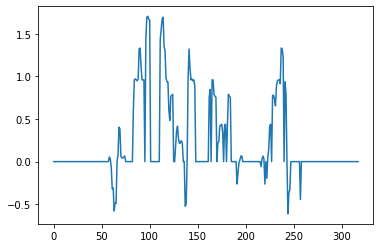

In [93]:
batch_np = batch.cpu().view([-1, 1+hparams.num_pos_samples + hparams.num_neg_samples, batch.shape[1], batch.shape[-1]]).numpy()
# for i in range(batch_np.shape[0]):
plt.plot(batch_np[10,0,:,0])
# plt.plot(batch_np[10,1,:,0])

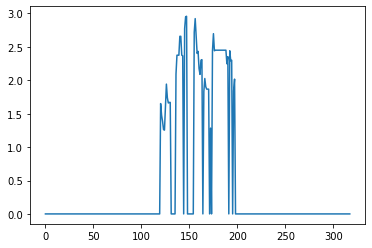

In [95]:
plt.plot(batch_np[10,2,:,0])

In [ ]:
criterion.similiarity_fn(anchor, neg)

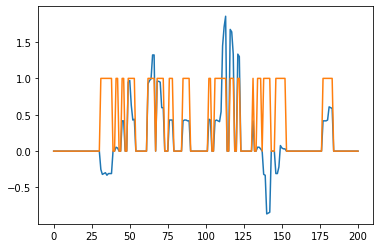

In [16]:
plt.plot(train_loader.dataset[1000][0])

In [98]:
embed_cat = torch.cat([anchor, pos, neg], dim=1).view(-1, anchor.shape[-1])
humm_embed = torch.cat([humm_anchor, humm_pos, humm_neg], dim=1).view(-1, anchor.shape[-1])
embed_cat = torch.cat([embed_cat, humm_embed, valid_emb], dim=0)
anchor_embedded = TSNE(n_components=2).fit_transform(embed_cat.squeeze().cpu().numpy())

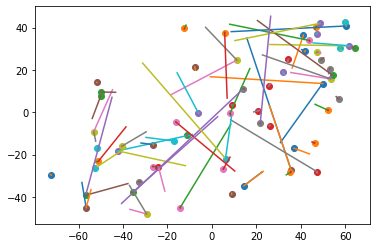

In [88]:
num_emb_per_melody = 1+hparams.num_pos_samples + hparams.num_neg_samples
for i in range(anchor.shape[0]):
    anchor_id = i*num_emb_per_melody
    plt.scatter(anchor_embedded[anchor_id,0], anchor_embedded[anchor_id,1])
    for j in range(hparams.num_pos_samples):
        plt.plot( [anchor_embedded[anchor_id,0], anchor_embedded[anchor_id+j+1,0]], [anchor_embedded[anchor_id,1], anchor_embedded[anchor_id+j+1,1]] )

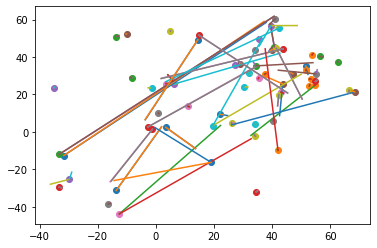

In [91]:
for i in range(humm_anchor.shape[0]):
    anchor_id = i*num_emb_per_melody+batch.shape[0]
    plt.scatter(anchor_embedded[anchor_id,0], anchor_embedded[anchor_id,1])
    for j in range(hparams.num_pos_samples):
        plt.plot( [anchor_embedded[anchor_id,0], anchor_embedded[anchor_id+j+1,0]], [anchor_embedded[anchor_id,1], anchor_embedded[anchor_id+j+1,1]] )

In [90]:
batch.shape[0]

448

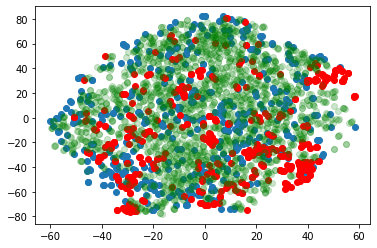

In [99]:
plt.scatter(anchor_embedded[:batch.shape[0],0], anchor_embedded[:batch.shape[0],1])
plt.scatter(anchor_embedded[batch.shape[0]:batch.shape[0]*2,0], anchor_embedded[batch.shape[0]:batch.shape[0]*2,1], color='red')
plt.scatter(anchor_embedded[batch.shape[0]*2:,0], anchor_embedded[batch.shape[0]*2:,1], color='green', alpha=0.2)

In [59]:
plt.scatter(anchor_embedded[:batch.shape[0],0], anchor_embedded[:batch.shape[0],1])


(168, 2)

In [61]:
humm_batch.shape

torch.Size([168, 539, 2])